In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks
import os, os.path
import re
import matplotlib.colors as colors
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import Model

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Introduction

Simulations of physical systems are an import tool which in recent year, due to the increase in available compuataional power, have become an essential part of analytical studies in fields such as theoretical optics, condensed matter and particle physics. Yet as these systems grow the computational power required to simulate them grows at an exponential rate, making it difficult to expand to larger systems. Machine learning techinques offer a potential solution to this problem by learning on smaller simulations in order to make predictions of larger systems.

The project looks at the field of simulations of theoretical optics, in partical looking at polaritonsgratings. The idea is that based on only 3 parameters, thh distance, eta and the etch width, it is possible to obtain the entire spectrum for the disperion of these 2 systems. These simulations take around 1.5 hours per system on a supercomputer. Given the around 5000 files, this requires a total time of 312.5 days worth of simulation. The objective is to create a ML model that takes these 3 parameters as inputs and gives you the simulation result with the aim to reduce computational times.

There are a total of 4803 data files, each of which contains the spectrum of the polaritons.

# Dataset Loading

The first step is to load the data that was saved in my Google Colaboraty. If required I can share the data, for the purpose of the project I have run the code and i will be attaching the final model as a h5 file which I will also be attaching.

Each graph corresponds to 100x500 size numpy array.

Some of the data points require are empty, which is solved using the isNan function. This function identifies the NaN values are replaces them with a very small value, in this case 1e-15. In addittion all of the data has been normalized!

In [2]:
def isNaN(num):
    return num != num

In [3]:
ind_d = 20
ind_eta = 7
ind_etch = 10

path = '/content/drive/MyDrive/PhD-Pavia/Data/'
fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
load = np.load(path+fname,allow_pickle=True)

In [4]:
path = '/content/drive/MyDrive/PhD-Pavia/Data/'
A_p_dict = {'D_eta_etch': [], 'Spectrum': []}
missing_files = 0

for ind_d in range(24):
    print(ind_d)
    for ind_eta in range(17):
        for ind_etch in range(13):
            condition = True
            try:
                fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
                load = np.load(path+fname,allow_pickle=True)
                condition = False

                eta = load.item()['eta']
                Dist = load.item()['D']
                etc_width = load.item()['etch_width']

                A_p_dict['D_eta_etch'].append([Dist, eta, etc_width])

                A_p  = load.item().get("A_p")
                A_p_norm = np.asarray(A_p)
                A_p_norm[isNaN(A_p)] = 1e-15
                A_p_norm =A_p_norm/np.max(A_p_norm, axis=(0), keepdims=True)

                A_p_dict['Spectrum'].append(A_p_norm)
            except:
                if condition:
                    missing_files += 1
                    if missing_files%50==0:
                      print(missing_files)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
1
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
2
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
3
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
4
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
5
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
6
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
7
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
8
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
9
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
10
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
11
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
12
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
13
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
14
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
15
26

Below you can see an example of the original graph below!

In [5]:
# Example of a graph
path = '/content/drive/MyDrive/PhD-Pavia/Data/'

ind_d = 6
ind_eta = 8
ind_etch = 10

fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
load = np.load(path+fname,allow_pickle=True)

K = load.item().get("K")
E = load.item().get("E")
A_p  = load.item().get("A_p")
A_p = np.asarray(A_p)
A_p[isNaN(A_p)] = 1e-15

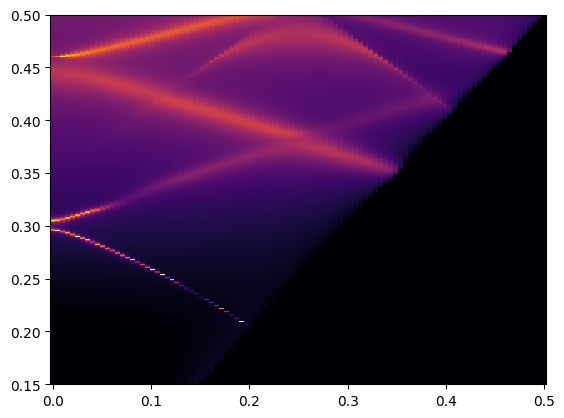

In [6]:
plt.ylim(np.min(E),np.max(E))
plt.pcolormesh(K,E,np.log10(A_p), cmap="inferno", vmin=-5,vmax=-2)

# ML Model

The first step of the ML model is to perform the train test split. In this case 80% of the data was used for training, around 4000 files.

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(A_p_dict['D_eta_etch'], A_p_dict['Spectrum'] , train_size=0.8)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [8]:
def create_model():
    dec_input = Input(shape=(3,), name='decoder-input')

    y = Dense(np.prod(200000))(dec_input)
    y = Reshape(target_shape=(125,25,64))(y)
    y = Conv2D(64, 5, padding='same', activation='relu')(y)
    y = Conv2D(64, 5, padding='same', activation='relu')(y)
    y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
    y = Conv2D(128, 5, padding='same', activation='relu')(y)
    y = Conv2D(128, 5, padding='same', activation='relu')(y)
    y = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(y)
    y = Conv2D(128, 5, padding='same', activation='relu')(y)
    y = Conv2D(128, 5, padding='same', activation='relu')(y)
    y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

    model = Model(inputs=dec_input, outputs=y)
    return model

model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')#, metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 200000)            800000    
                                                                 
 reshape (Reshape)           (None, 125, 25, 64)       0         
                                                                 
 conv2d (Conv2D)             (None, 125, 25, 64)       102464    
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 25, 64)       102464    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 250, 50, 64)      36928     
 nspose)                                                         
                                                             

The following is the trainig that was performed for 5.5h on A100 GPU's on Google drive

In [17]:
epochs = 600
batch_size = 200

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

loss = history.history['loss']

save_path = f"/content/drive/MyDrive/PhD-Pavia/Ap_model_{epochs}epochs_batchsize{batch_size}.h5"
tf.keras.models.save_model(model, save_path)

Epoch 1/600
20/20 [==============================] - 115s 3s/step - loss: 0.0739
Epoch 2/600
20/20 [==============================] - 33s 2s/step - loss: 0.0557
Epoch 3/600
20/20 [==============================] - 33s 2s/step - loss: 0.0506
Epoch 4/600
20/20 [==============================] - 33s 2s/step - loss: 0.0483
Epoch 5/600
20/20 [==============================] - 33s 2s/step - loss: 0.0473
Epoch 6/600
20/20 [==============================] - 33s 2s/step - loss: 0.0462
Epoch 7/600
20/20 [==============================] - 33s 2s/step - loss: 0.0458
Epoch 8/600
20/20 [==============================] - 33s 2s/step - loss: 0.0452
Epoch 9/600
20/20 [==============================] - 33s 2s/step - loss: 0.0450
Epoch 10/600
20/20 [==============================] - 33s 2s/step - loss: 0.0443
Epoch 11/600
20/20 [==============================] - 33s 2s/step - loss: 0.0431
Epoch 12/600
20/20 [==============================] - 33s 2s/step - loss: 0.0433
Epoch 13/600
20/20 [================

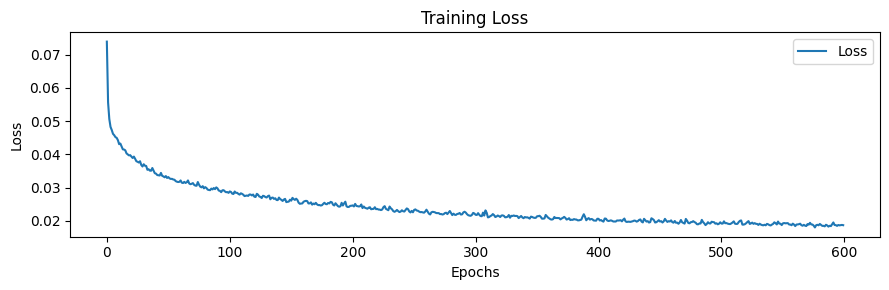

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt


# Plot the loss and accuracy graphs
plt.figure(figsize=(9, 3))

plt.plot(loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/PhD-Pavia/losses.png')


# Test

1/1 [==============================] - 0s 20ms/step


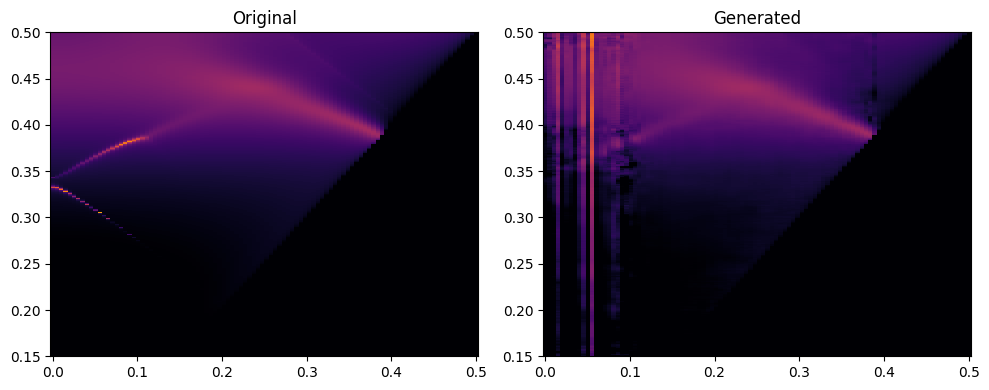

In [24]:
# Example of a graph
path = '/content/drive/MyDrive/PhD-Pavia/Data/'

ind_d = 2
ind_eta = 12
ind_etch = 4

fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
load = np.load(path+fname,allow_pickle=True)

eta = load.item()['eta']
Dist = load.item()['D']
etc_width = load.item()['etch_width']

input_sample = np.array([Dist, eta , etc_width])
input_sample = input_sample.reshape(1, 3)
prediction = model.predict(input_sample)
prediction = prediction[0,:,:,0]
prediction[prediction<1e-15] = 1e-15

#put the 2 figures next to each other
K = load.item().get("K")
E = load.item().get("E")
A_p  = load.item().get("A_p")
A_p = np.asarray(A_p)
A_p[isNaN(A_p)] = 1e-15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot the data on the first subplot (axs[0])
axs[0].set_ylim(np.min(E),np.max(E))
axs[0].pcolormesh(K,E,np.log10(A_p), cmap="inferno", vmin=-5,vmax=-2)
axs[0].set_title('Original')

# Plot the data on the second subplot (axs[1])
axs[1].set_title('Generated')
prediction = prediction * np.max(A_p, axis=(0), keepdims=True)
axs[1].set_ylim(np.min(E),np.max(E))
axs[1].pcolormesh(K,E,np.log10(prediction), cmap="inferno", vmin=-5,vmax=-2)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

1/1 [==============================] - 0s 21ms/step


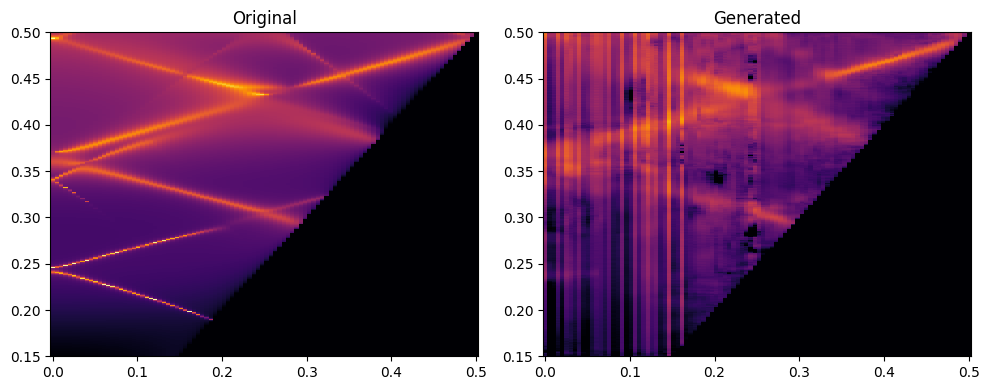

In [25]:
# Example of a graph
path = '/content/drive/MyDrive/PhD-Pavia/Data/'

ind_d = 8
ind_eta = 5
ind_etch = 8

fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
load = np.load(path+fname,allow_pickle=True)

eta = load.item()['eta']
Dist = load.item()['D']
etc_width = load.item()['etch_width']

input_sample = np.array([Dist, eta , etc_width])
input_sample = input_sample.reshape(1, 3)
prediction = model.predict(input_sample)
prediction = prediction[0,:,:,0]
prediction[prediction<1e-15] = 1e-15

#put the 2 figures next to each other
K = load.item().get("K")
E = load.item().get("E")
A_p  = load.item().get("A_p")
A_p = np.asarray(A_p)
A_p[isNaN(A_p)] = 1e-15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot the data on the first subplot (axs[0])
axs[0].set_ylim(np.min(E),np.max(E))
axs[0].pcolormesh(K,E,np.log10(A_p), cmap="inferno", vmin=-5,vmax=-2)
axs[0].set_title('Original')

# Plot the data on the second subplot (axs[1])
axs[1].set_title('Generated')
prediction = prediction * np.max(A_p, axis=(0), keepdims=True)
axs[1].set_ylim(np.min(E),np.max(E))
axs[1].pcolormesh(K,E,np.log10(prediction), cmap="inferno", vmin=-5,vmax=-2)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

1/1 [==============================] - 0s 21ms/step


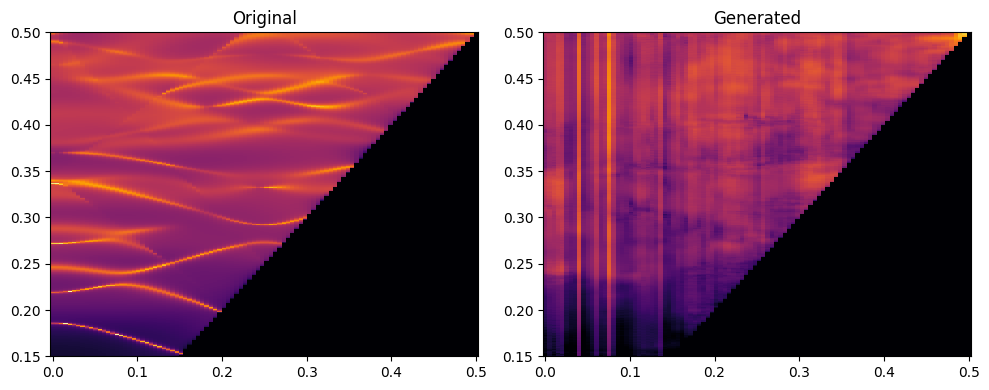

In [26]:
# Example of a graph
path = '/content/drive/MyDrive/PhD-Pavia/Data/'

ind_d = 20
ind_eta = 12
ind_etch = 4

fname = f'BH_{ind_d}_{ind_eta}_{ind_etch}_D_eta_etch.npy'
load = np.load(path+fname,allow_pickle=True)

eta = load.item()['eta']
Dist = load.item()['D']
etc_width = load.item()['etch_width']

input_sample = np.array([Dist, eta , etc_width])
input_sample = input_sample.reshape(1, 3)
prediction = model.predict(input_sample)
prediction = prediction[0,:,:,0]
prediction[prediction<1e-15] = 1e-15

#put the 2 figures next to each other
K = load.item().get("K")
E = load.item().get("E")
A_p  = load.item().get("A_p")
A_p = np.asarray(A_p)
A_p[isNaN(A_p)] = 1e-15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot the data on the first subplot (axs[0])
axs[0].set_ylim(np.min(E),np.max(E))
axs[0].pcolormesh(K,E,np.log10(A_p), cmap="inferno", vmin=-5,vmax=-2)
axs[0].set_title('Original')

# Plot the data on the second subplot (axs[1])
axs[1].set_title('Generated')
prediction = prediction * np.max(A_p, axis=(0), keepdims=True)
axs[1].set_ylim(np.min(E),np.max(E))
axs[1].pcolormesh(K,E,np.log10(prediction), cmap="inferno", vmin=-5,vmax=-2)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()